In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

%matplotlib inline
plt.style.use('ggplot')

In [2]:
pd.options.display.max_columns = 0
pd.options.display.max_rows = 20
#pd.options.display.max_rows = None


In [3]:
listings0 = pd.read_csv("data/listings.csv")
listings0.shape

(59824, 29)

### Data exploration

In [4]:
listings0.head()

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,has_availability,host_id,id,instant_bookable,latitude,longitude,metropolitan,name,price,property_type,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,state,weekly_price,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,NaN,119445,7949480,f,40.852054,-73.788680,NYC,City Island Sanctuary relaxing BR & Bath w Par...,99.0,House,10.0,10.0,10.0,10.0,100.0,10.0,Private room,NY,NaN,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,NaN,9117975,16042478,t,40.853491,-73.788607,NYC,WATERFRONT STUDIO APARTMENT,200.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,Private room,NY,NaN,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,NaN,9815788,1886820,f,40.841144,-73.783052,NYC,Quaint City Island Community.,300.0,House,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,NY,NaN,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,Real Bed,1.0,1.0,strict,long island city,NaN,13886510,6627449,f,40.849775,-73.786609,NYC,Large 1 BDRM in Great location,125.0,Apartment,10.0,10.0,10.0,10.0,93.0,10.0,Entire home/apt,NY,775.0,10464
4,4.0,"{Internet,""Wireless Internet"",""Air conditionin...",17,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,NaN,28811542,5557381,t,40.850024,-73.789328,NYC,Quaint City Island Home,69.0,House,10.0,10.0,10.0,10.0,97.0,10.0,Private room,NY,350.0,10464


The relevant features we will are:

1. **city:** Neighborhood/city the property located in
2. **id:** ID of the listed property
3. **price:** One-night rental price of the property, in U.S. dollars
4. **property_type:** Type of the property
5. **state:** State name Gross domes
6. **zipcode:** Zipcode of the property’s location
7. **accommodates:** List of amenities available in theproperty, comma-delimited
    

In [5]:
listings = listings0[['accommodates', 'availability_30', 'bathrooms', 'bedrooms','beds', 'cancellation_policy',
          'city', 'host_id', 'id', 'instant_bookable', 'latitude', 'longitude', 'metropolitan', 'price',
          'property_type', 'room_type', 'state', 'weekly_price', 'zipcode']]

In [6]:
listings.describe(include = 'all')

,accommodates,availability_30,bathrooms,bedrooms,beds,cancellation_policy,city,host_id,id,instant_bookable,latitude,longitude,metropolitan,price,property_type,room_type,state,weekly_price,zipcode
count,59763.000000,59824.000000,59622.000000,59729.000000,59715.000000,59824,59778,5.982400e+04,5.982400e+04,59824,59824.000000,59824.000000,59824,59824.000000,59820,59824,59824,13438.000000,58998
unique,NaN,NaN,NaN,NaN,NaN,7,133,NaN,NaN,2,NaN,NaN,5,NaN,32,3,9,NaN,474
top,NaN,NaN,NaN,NaN,NaN,strict,new york,NaN,NaN,f,NaN,NaN,NYC,NaN,Apartment,Entire home/apt,NY,NaN,11211
freq,NaN,NaN,NaN,NaN,NaN,25278,19566,NaN,NaN,47009,NaN,NaN,40740,NaN,46149,32103,40738,NaN,2043
mean,3.031960,7.976448,1.183447,1.221969,1.626107,NaN,NaN,3.100695e+07,1.007171e+07,NaN,40.651362,-76.674881,NaN,159.009378,NaN,NaN,NaN,856.471201,NaN
std,1.999427,10.062641,0.483726,0.775982,1.128178,NaN,NaN,3.216733e+07,5.507015e+06,NaN,0.862090,7.139989,NaN,236.200222,NaN,NaN,NaN,712.856777,NaN
min,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,7.200000e+01,5.900000e+02,NaN,38.823403,-105.094563,NaN,0.000000,NaN,NaN,NaN,70.000000,NaN
25%,2.000000,0.000000,1.000000,1.000000,1.000000,NaN,NaN,5.453285e+06,5.477726e+06,NaN,40.673848,-76.981725,NaN,70.000000,NaN,NaN,NaN,450.000000,NaN
50%,2.000000,3.000000,1.000000,1.000000,1.000000,NaN,NaN,1.965590e+07,1.022793e+07,NaN,40.722133,-73.972984,NaN,109.000000,NaN,NaN,NaN,675.000000,NaN
75%,4.000000,13.000000,1.000000,1.000000,2.000000,NaN,NaN,4.667932e+07,1.505785e+07,NaN,40.791820,-73.942720,NaN,176.000000,NaN,NaN,NaN,1000.000000,NaN


### cleaning the ```zipcode``` column 

In [7]:
listings['zipcode'] = listings['zipcode'].astype('str')

#listings[listings['len'] < 5]
listings['zipcode_clean'] = listings['zipcode']
listings['zipcode_clean'][listings['zipcode_clean'].isin(['nan', '1m', ' '])] = ''

listings['zipcode_clean'] = listings['zipcode_clean'].apply( lambda x : x.zfill(5))
listings['zipcode_clean'] = list(listings['zipcode_clean'].str.slice(0,5))

(listings[
    ['zipcode', 'zipcode_clean']
][listings['zipcode'] != listings['zipcode_clean']]
  .drop_duplicates()
 .sort_values(by = 'zipcode'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

,zipcode,zipcode_clean
52757,,00000
50499,02108 02111,02108
51843,02134-1704,02134
22179,10000.0,10000
17351,10001.0,10001
...,...,...
41568,80239.0,80239
41253,80246.0,80246
41215,80247.0,80247
41571,80249.0,80249


## Look into the property types of our interest

/opt/conda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


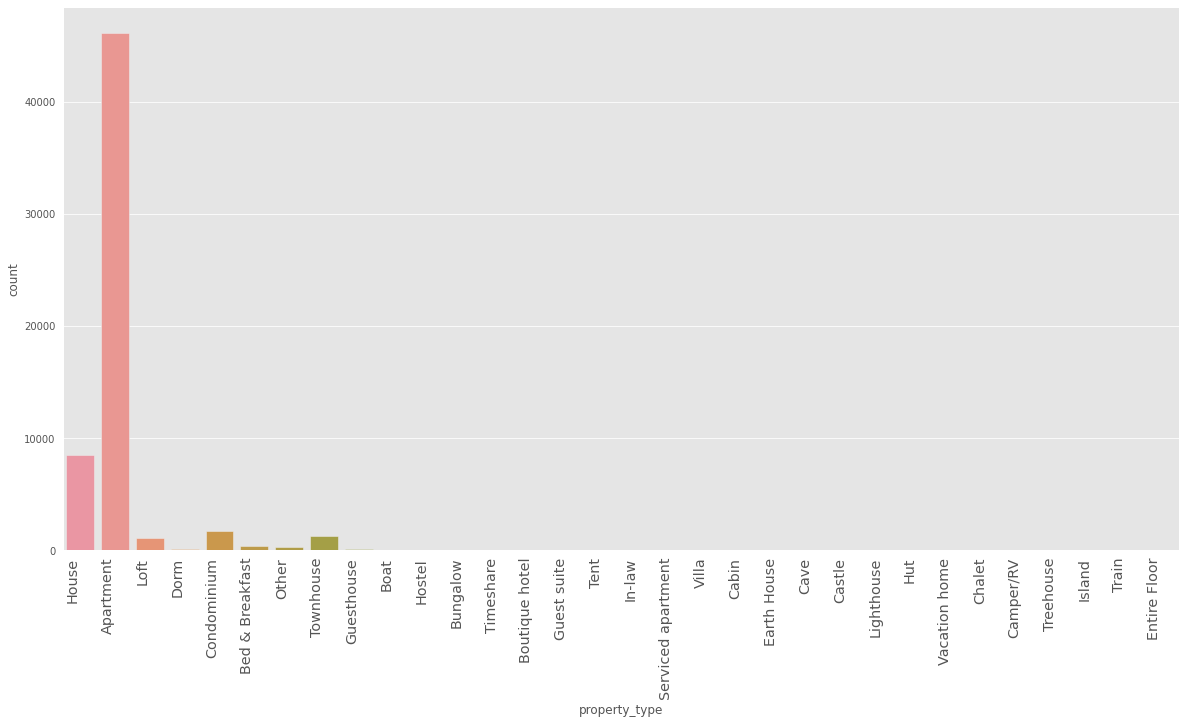

In [8]:
plt.figure(figsize=(20, 10))
sns.countplot('property_type',data=listings)
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

In [9]:
print("listings shape: " + str(listings.shape))
listings_filt = (listings[listings['property_type'].isin(['Apartment',
'House',
'Condominium',
'Townhouse',
'Loft',
'Bed & Breakfast'])] )
print("listings_filt shape properties filter: " + str(listings_filt.shape))
listings_filt = listings_filt[listings_filt['zipcode_clean'] != '00000']
print("listings_filt shape zipcode filter: " + str(listings_filt.shape))

listings shape: (59824, 20)
listings_filt shape properties filter: (59068, 20)
listings_filt shape zipcode filter: (58248, 20)


In [10]:
listings_filt.groupby("property_type")["price"].describe().sort_values(by="std")

,count,mean,std,min,25%,50%,75%,max
property_type,,,,,,,,
Bed & Breakfast,333.0,124.792793,100.365697,28.0,70.0,99.0,150.00,1100.0
Apartment,45496.0,148.791630,192.839159,0.0,75.0,110.0,175.00,10000.0
Loft,1090.0,207.348624,274.594647,14.0,80.0,135.0,220.00,3500.0
Condominium,1698.0,209.196702,286.153700,14.0,85.0,130.0,220.00,5150.0
Townhouse,1267.0,208.790055,306.088424,10.0,75.0,119.0,220.00,3600.0
House,8364.0,189.346844,371.917232,0.0,60.0,90.0,176.25,8000.0


### Looking how works the price and the type of room

In [11]:
listings_filt[listings_filt['id'] == 9513511]

,accommodates,availability_30,bathrooms,bedrooms,beds,cancellation_policy,city,host_id,id,instant_bookable,latitude,longitude,metropolitan,price,property_type,room_type,state,weekly_price,zipcode,zipcode_clean
12,4.0,0,1.0,2.0,2.0,strict,sunnysidebronx,49293611,9513511,f,40.857532,-73.866055,NYC,130.0,Apartment,Entire home/apt,NY,NaN,10462,10462


Making some comparisons between and the property that appears below the price seems is for the entire property no matter the ammount of hosts(1-4) **the room_type is Entire home/apt**

https://es.airbnb.com/rooms/33996721?source_impression_id=p3_1607654687_VwuIYsi17KyB1SFb&guests=4&adults=4&check_in=2020-12-10&check_out=2020-12-11

In [12]:
listings_filt[listings_filt['id'] == 715270]

,accommodates,availability_30,bathrooms,bedrooms,beds,cancellation_policy,city,host_id,id,instant_bookable,latitude,longitude,metropolitan,price,property_type,room_type,state,weekly_price,zipcode,zipcode_clean
7,3.0,5,1.0,1.0,2.0,strict,sunnysidebronx,3684360,715270,f,40.859559,-73.870669,NYC,39.0,Apartment,Private room,NY,NaN,10467,10467


https://www.airbnb.com.co/rooms/715270?_set_bev_on_new_domain=1607653226_NjA2YWE1MWJiZThm&source_impression_id=p3_1607655943_pGlw%2B57yLA4ssX5m&guests=1&adults=1&check_in=2021-02-23&check_out=2021-02-25
the price change with the number of hosts but not proportional to the inicial price, the amount increase about 12$ per host **the room_type is private**

In [13]:
listings_filt.groupby(['property_type', 'room_type'])['room_type'].count()

property_type    room_type      
Apartment        Entire home/apt    25568
                 Private room       18656
                 Shared room         1272
Bed & Breakfast  Entire home/apt       37
                 Private room         265
                 Shared room           31
Condominium      Entire home/apt     1074
                 Private room         602
                 Shared room           22
House            Entire home/apt     3425
                 Private room        4751
                 Shared room          188
Loft             Entire home/apt      623
                 Private room         430
                 Shared room           37
Townhouse        Entire home/apt      620
                 Private room         624
                 Shared room           23
Name: room_type, dtype: int64

Probably our investor is not interesting to live in the property that want to rent, so i think the type of room that we are interesting is on the ```"Entire home/apt"``` 

#### Taking only the ```"Entire home/apt"``` properties

In [14]:
listings_filt2 = listings_filt[listings_filt['room_type'] == 'Entire home/apt']
listings_filt2.shape

(31347, 20)

In [15]:
tem_num_properties = (
    pd.DataFrame(
    listings_filt2
    .groupby("zipcode_clean" )['zipcode_clean']
        .count()
        .sort_values(ascending = False))
    .rename(columns = {'zipcode_clean' : 'num_properties'})
    .reset_index()
    
)
tem_num_properties

,zipcode_clean,num_properties
0,11211,981
1,20009,949
2,20002,871
3,20001,778
4,10002,684
...,...,...
339,60453,1
340,60603,1
341,60636,1
342,60638,1


In [16]:
listings_filt2 = (listings_filt2
                 .merge(tem_num_properties, 
                        #how = 'left', 
                        on = 'zipcode_clean')
                )
#listings_filt[listings_filt['num_properties'].isna()]
listings_filt2.shape

(31347, 21)

In [17]:
listings_filt3 = listings_filt2[listings_filt2['num_properties'] >= 50]
listings_filt3.shape

(28947, 21)

In [18]:
listings_filt3.head()

,accommodates,availability_30,bathrooms,bedrooms,beds,cancellation_policy,city,host_id,id,instant_bookable,latitude,longitude,metropolitan,price,property_type,room_type,state,weekly_price,zipcode,zipcode_clean,num_properties
41,4.0,0,1.0,2.0,2.0,flexible,new york,7809661,4357134,f,40.771715,-73.917688,NYC,200.0,Apartment,Entire home/apt,NY,NaN,11102,11102,109
42,2.0,0,1.0,1.0,1.0,strict,astoria,73541674,16975094,f,40.773187,-73.916874,NYC,100.0,Apartment,Entire home/apt,NY,NaN,11102,11102,109
43,3.0,0,1.0,1.0,1.0,flexible,queens,5226800,12956315,f,40.773737,-73.919031,NYC,100.0,Apartment,Entire home/apt,NY,NaN,11102,11102,109
44,3.0,0,1.0,1.0,2.0,flexible,queens,243275,13055480,f,40.773485,-73.917991,NYC,110.0,Apartment,Entire home/apt,NY,NaN,11102,11102,109
45,4.0,0,2.0,2.0,2.0,strict,queens,71378038,12972200,f,40.776876,-73.927829,NYC,125.0,Apartment,Entire home/apt,NY,NaN,11102,11102,109


In [ ]:
realestate_df= pd.read_csv('data/real_estate.csv')
realestate_df

,type,zipcode,city,state,metro,county,size_rank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,ZHVI,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,886900,893400,888500,883000,887900,895100,901400,911100,915300,911400,908300,908600,904200,899400,901600,911500,926600,948100,970000,979800,983700,993700,1007800,1031000.0,1055800.0,1063500.0,1062900.0,1080800,1109400,1132500,1137500,1137700,1152700,1156000.0,1140200,1130000,1131900,1149600,1198400,1247000
1,ZHVI,60657,Chicago,IL,Chicago,Cook,2,146700.0,146500.0,146300.0,146300.0,146800.0,147100.0,147300.0,147800.0,148600.0,149100.0,149600.0,151100.0,153200.0,155100.0,157200.0,159100.0,160000.0,160800.0,162200.0,163200.0,164100.0,165600.0,167400.0,168000.0,168100.0,168500.0,168900.0,169100.0,170200.0,172100.0,174500.0,177100.0,180500.0,...,298800,298700,296700,296500,299700,303200,304700,305200,306800,309000,308800,306700,306600,308800,310200,310000,310400,310000,310300,311800,312500,311600,311800,313100.0,315000.0,317000.0,317500.0,317500,317900,318600,318200,318100,318800,320200.0,320800,322000,323800,326100,327800,329100
2,ZHVI,60614,Chicago,IL,Chicago,Cook,3,198000.0,195500.0,194200.0,193800.0,193900.0,194500.0,195900.0,197900.0,200100.0,199700.0,197700.0,197600.0,199700.0,200500.0,201000.0,202100.0,202700.0,202300.0,202500.0,203000.0,203200.0,203800.0,205200.0,206900.0,209100.0,210900.0,213700.0,217400.0,220600.0,222200.0,223300.0,224300.0,225900.0,...,361900,363900,365100,367200,370100,370900,368800,365200,364000,366900,368700,363600,357600,358000,359900,359300,359100,362000,368700,379500,386800,390300,393200,397200.0,400500.0,404000.0,403500.0,401400,400100,400700,401900,406000,414100,417800.0,417400,418400,414100,404100,406400,415500
3,ZHVI,79936,El Paso,TX,El Paso,El Paso,4,70800.0,71000.0,71000.0,71400.0,71200.0,71600.0,72600.0,73100.0,72800.0,72800.0,72900.0,73100.0,73100.0,73300.0,73500.0,73900.0,74500.0,74900.0,75200.0,75400.0,75800.0,76200.0,76500.0,76700.0,76500.0,76400.0,76500.0,76300.0,76100.0,75900.0,75800.0,75800.0,75800.0,...,110600,110600,110800,111200,111500,111400,111300,111400,111500,111600,111700,111700,111600,111500,111500,111500,111700,111800,111800,111800,111500,111200,111200,111200.0,111200.0,111500.0,112000.0,112500,113200,113700,113800,113900,114100,114500.0,114900,115000,114700,114700,114800,114700
4,ZHVI,60640,Chicago,IL,Chicago,Cook,5,102300.0,101300.0,100700.0,100600.0,100700.0,101300.0,102300.0,103200.0,104400.0,105200.0,105600.0,106400.0,106800.0,106600.0,106900.0,107900.0,109100.0,109600.0,109000.0,108200.0,107900.0,107900.0,108000.0,108900.0,110900.0,112800.0,114100.0,115400.0,116400.0,117000.0,117800.0,119400.0,120800.0,...,183900,185200,186100,186100,186500,188900,191000,192400,193200,193400,192200,191600,192700,195700,197200,195700,193500,192600,193400,195200,195900,195900,196000,196000.0,195600.0,195800.0,195700.0,197500,199600,199900,198800,199200,200100,201500.0,203000,205100,206700,206500,206200,206700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29106,ZRI,12720,Bethel,NY,NaN,Sullivan,15907,NaN,NaN,NaN,

### FIll Nan Rows with Average values

### Years Columns

In [ ]:
yeardf= realestate_df.iloc[:, 250:]
m = yeardf.mean(axis=1)
for i, col in enumerate(yeardf):
    yeardf.iloc[:, i] = yeardf.iloc[:, i].fillna(m) # Se agrega el promedio del valor a las celdas Naa
yeardf

,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,1109400,1132500,1137500,1137700,1152700,1156000.0,1140200,1130000,1131900,1149600,1198400,1247000
1,317900,318600,318200,318100,318800,320200.0,320800,322000,323800,326100,327800,329100
2,400100,400700,401900,406000,414100,417800.0,417400,418400,414100,404100,406400,415500
3,113200,113700,113800,113900,114100,114500.0,114900,115000,114700,114700,114800,114700
4,199600,199900,198800,199200,200100,201500.0,203000,205100,206700,206500,206200,206700
...,...,...,...,...,...,...,...,...,...,...,...,...
29106,1201,1191,1185,1181,1174,1167.0,1156,1162,1175,1194,1202,1206
29107,1772,1774,1769,1772,1775,1780.0,1786,1790,1797,1798,1796,1795
29108,4063,4061,4048,4005,3888,3729.0,3563,3493,3474,3496,3488,3471
29109,991,998,1007,1018,1035,1052.0,1061,1060,1058,1065,1074,1080


###  Info Columns

In [ ]:
realecateg=realestate_df.iloc[:, :7]
#realecateg

In [ ]:
realestate_df= pd.concat([realecateg, yeardf], axis=1)
realestate_df.metro.fillna("Empty", inplace=True)
#realestate_df
#realestate_df.isna().sum().sum()

### Melting date 2016 -2017 columns on a single column in Data-Set:

In [ ]:
yeardf= yeardf.columns.tolist() # Listado de años y meses de la df realstate
#yearlist
realestate_df = pd.melt(realestate_df, id_vars=['type','zipcode','city','state','metro','county','size_rank'], value_vars= yeardf , var_name='date', value_name= 'Value')
realestate_df

,type,zipcode,city,state,metro,county,size_rank,date,Value
0,ZHVI,10025,New York,NY,New York,New York,1,2016-07,1109400.0
1,ZHVI,60657,Chicago,IL,Chicago,Cook,2,2016-07,317900.0
2,ZHVI,60614,Chicago,IL,Chicago,Cook,3,2016-07,400100.0
3,ZHVI,79936,El Paso,TX,El Paso,El Paso,4,2016-07,113200.0
4,ZHVI,60640,Chicago,IL,Chicago,Cook,5,2016-07,199600.0
...,...,...,...,...,...,...,...,...,...
349327,ZRI,12720,Bethel,NY,Empty,Sullivan,15907,2017-06,1206.0
349328,ZRI,1338,Shelburne Falls,MA,Greenfield Town,Franklin,15908,2017-06,1795.0
349329,ZRI,21405,Annapolis,MD,Baltimore,Anne Arundel,15909,2017-06,3471.0
349330,ZRI,85220,Apache Junction,AZ,Phoenix,Pinal,15910,2017-06,1080.0


### Creating month and year columns

In [ ]:
realestate_df['year'] = pd.DatetimeIndex(realestate_df['date']).year
realestate_df['month'] = pd.DatetimeIndex(realestate_df['date']).month
#realestate_df

### Fill zipcode with 0 from Real Estate df

In [ ]:
realestate_df['zipcode'] = realestate_df['zipcode'].astype('str')

#realestate_df[realestate_df['len'] < 5]
realestate_df['zipcode_clean'] = realestate_df['zipcode']
realestate_df['zipcode_clean'][realestate_df['zipcode_clean'].isin(['nan', '1m', ' '])] = ''

realestate_df['zipcode_clean'] = realestate_df['zipcode_clean'].apply( lambda x : x.zfill(5))
realestate_df['zipcode_clean'] = list(realestate_df['zipcode_clean'].str.slice(0,5))

(realestate_df[
    ['zipcode', 'zipcode_clean']
][realestate_df['zipcode'] != realestate_df['zipcode_clean']]
  .drop_duplicates()
 .sort_values(by = 'zipcode'))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,zipcode,zipcode_clean
5480,1001,01001
3942,1002,01002
10325,1005,01005
6450,1007,01007
12995,1008,01008
...,...,...
12767,8887,08887
8085,8889,08889
1935,8901,08901
1615,8902,08902


### Creating ZHVI df

In [ ]:
rszhvi= realestate_df[ realestate_df['type'].isin(['ZHVI'])]
rszhvi

,type,zipcode,city,state,metro,county,size_rank,date,Value,year,month,zipcode_clean
0,ZHVI,10025,New York,NY,New York,New York,1,2016-07,1109400.0,2016,7,10025
1,ZHVI,60657,Chicago,IL,Chicago,Cook,2,2016-07,317900.0,2016,7,60657
2,ZHVI,60614,Chicago,IL,Chicago,Cook,3,2016-07,400100.0,2016,7,60614
3,ZHVI,79936,El Paso,TX,El Paso,El Paso,4,2016-07,113200.0,2016,7,79936
4,ZHVI,60640,Chicago,IL,Chicago,Cook,5,2016-07,199600.0,2016,7,60640
...,...,...,...,...,...,...,...,...,...,...,...,...
333416,ZHVI,97102,Arch Cape,OR,Astoria,Clatsop,13196,2017-06,602000.0,2017,6,97102
333417,ZHVI,36564,Fairhope,AL,Daphne,Baldwin,13197,2017-06,551100.0,2017,6,36564
333418,ZHVI,3293,Woodstock,NH,Claremont,Grafton,13198,2017-06,171300.0,2017,6,03293
333419,ZHVI,21405,Annapolis,MD,Baltimore,Anne Arundel,13199,2017-06,785500.0,2017,6,21405


### Groupby zipcode

In [ ]:
realestate_df2 = rszhvi.groupby(['zipcode_clean'])['Value'].mean().reset_index()
realestate_df2

,zipcode_clean,Value
0,01001,192841.666667
1,01002,311858.333333
2,01005,219958.333333
3,01007,263100.000000
4,01008,217191.666667
...,...,...
13195,99705,211191.666667
13196,99709,229425.000000
13197,99712,243258.333333
13198,99801,323833.333333


In [ ]:
#Verificacion de promedio de meses de propiedad
#rszhvi[['city','zipcode','Value']].groupby(['city', 'zipcode']).agg(['count']) 


In [ ]:
print("listings shape: " +  str(listings_filt3.shape))
print("real_estate shape: " +  str(realestate_df2.shape))
print("left join between listings and real_estate:" +
    str(pd.DataFrame(
    listings_filt3['zipcode_clean'])
 .merge(
     pd.DataFrame(realestate_df2['zipcode_clean']),
     how = 'left',
     on = 'zipcode_clean' ).shape)
)
print("inner join between listings and real_estate:" +
    str(pd.DataFrame(
    listings_filt3['zipcode_clean'])
 .merge(
     pd.DataFrame(realestate_df2['zipcode_clean']),
     how = 'inner',
     on = 'zipcode_clean' ).shape)
)

print("right join between listings and real_estate:" +
    str(pd.DataFrame(
    listings_filt3['zipcode_clean'])
 .merge(
     pd.DataFrame(realestate_df2['zipcode_clean']),
     how = 'right',
     on = 'zipcode_clean' ).shape)
)


listings shape: (28947, 21)
real_estate shape: (13200, 2)
left join between listings and real_estate:(28947, 1)
inner join between listings and real_estate:(20137, 1)
right join between listings and real_estate:(33242, 1)


## Merge Real Estate and listings_filt3

In [ ]:
listings_filt4= listings_filt3.set_index('zipcode_clean').join(realestate_df2.set_index('zipcode_clean'), how='left',lsuffix = '_left', rsuffix = '_right')
listings_filt4=listings_filt4.reset_index()
listings_filt4

,zipcode_clean,accommodates,availability_30,bathrooms,bedrooms,beds,cancellation_policy,city,host_id,id,instant_bookable,latitude,longitude,metropolitan,price,property_type,room_type,state,weekly_price,zipcode,num_properties,Value
0,02108,3.0,7,1.0,1.0,1.0,strict,boston,5578043,2657905,t,42.364847,-71.052334,boston,99.0,Apartment,Entire home/apt,MA,NaN,02108,66,1.107642e+06
1,02108,6.0,12,1.0,2.0,4.0,strict,boston,5578043,2658094,t,42.366658,-71.051928,boston,179.0,Apartment,Entire home/apt,MA,NaN,02108,66,1.107642e+06
2,02108,2.0,0,NaN,1.0,NaN,strict,boston,5578043,1426754,t,42.364824,-71.053707,boston,99.0,Apartment,Entire home/apt,MA,NaN,02108,66,1.107642e+06
3,02108,3.0,0,1.0,1.0,1.0,strict,boston,26988,67774,f,42.358669,-71.063315,boston,110.0,Apartment,Entire home/apt,MA,1300.0,02108,66,1.107642e+06
4,02108,4.0,1,2.5,2.0,1.0,moderate,boston,280497,5659866,f,42.357816,-71.066659,boston,200.0,Apartment,Entire home/apt,MA,NaN,02108,66,1.107642e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28942,80223,4.0,12,1.0,1.0,1.0,strict,denver,10660916,11319556,t,39.719874,-104.993262,denver,50.0,Apartment,Entire home/apt,CO,NaN,80223.0,60,2.733333e+05
28943,80223,4.0,16,1.0,1.0,1.0,strict,denver,31871797,11343629,f,39.719441,-104.993176,denver,50.0,Apartment,Entire home/apt,CO,NaN,80223.0,60,2.733333e+05
28944,80223,3.0,3,2.0,2.0,2.0,strict,denver,43616556,8271792,f,39.720611,-104.994369,denver,110.0,House,Entire home/apt,CO,700.0,80223.0,60,2.733333e+05
28945,80223,3.0,6,1.0,2.0,2.0,moderate,denver,17347654,4191778,f,39.719120,-104.995356,denver,96.0,House,Entire home/apt,CO,640.0,80223.0,60,2.733333e+05


In [ ]:
calendar = pd.read_csv("data/calendar.csv")
print(str(calendar.shape))
calendar.head()

(21841235, 5)


,listing_id,date,available,price,metro_area
0,2515,2018-03-05,t,69.0,NYC
1,2515,2018-03-04,t,69.0,NYC
2,2515,2018-03-03,t,69.0,NYC
3,2515,2018-03-02,t,69.0,NYC
4,2515,2018-03-01,t,69.0,NYC


In [ ]:
calendar = calendar[calendar['available']== 't']

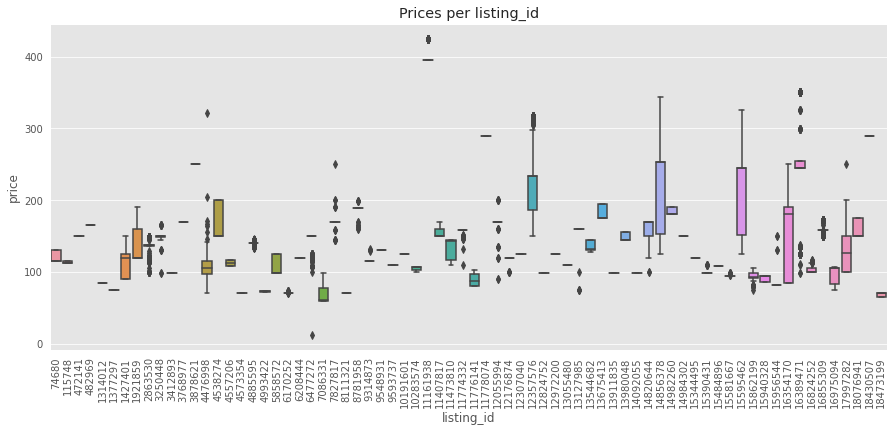

In [ ]:
# Let's create a sample of properties to check it's price distribution in calendar

# testing = listings_filt2['id'].sample(10).reset_index(drop=True)

testing = listings_filt3['id'][listings_filt3['zipcode_clean']=='11102'].reset_index(drop=True)



# outfortest.dropna(inplace=True)

# testingfreeze=testing

out1 = calendar[(calendar['listing_id'].isin(testing))].dropna()

plt.figure(figsize=(15,6))

g=sns.boxplot(y='price',x='listing_id',data=out1)

g.set_title("Prices per listing_id")

g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [ ]:
calendar.columns

Index(['listing_id', 'date', 'available', 'price', 'metro_area'], dtype='object')

### Union listing and calendar price modeling

In [ ]:
calendar[['listing_id','price']].groupby(['listing_id','price']).count()

Empty DataFrame
Columns: []
Index: [(590, 61.0), (590, 72.0), (592, 45.0), (686, 60.0), (686, 65.0), (686, 70.0), (930, 95.0), (2384, 55.0), (2384, 58.0), (2384, 59.0), (2384, 60.0), (2515, 59.0), (2515, 69.0), (2515, 79.0), (2515, 82.0), (2515, 89.0), (2515, 94.0), (2515, 95.0), (2515, 99.0), (2515, 129.0), (2515, 169.0), (2595, 201.0), (2595, 205.0), (2595, 211.0), (2595, 212.0), (2595, 213.0), (2595, 214.0), (2595, 215.0), (2595, 216.0), (2595, 217.0), (2595, 218.0), (2595, 219.0), (2595, 220.0), (2595, 221.0), (2595, 223.0), (2595, 225.0), (3353, 32.0), (3353, 33.0), (3353, 34.0), (3353, 35.0), (3353, 36.0), (3362, 335.0), (3362, 353.0), (3362, 399.0), (3362, 413.0), (3362, 423.0), (3362, 433.0), (3362, 443.0), (3362, 453.0), (3362, 463.0), (3362, 473.0), (3362, 483.0), (3596, 36.0), (3596, 38.0), (3596, 45.0), (3596, 46.0), (3596, 50.0), (3596, 51.0), (3596, 56.0), (3596, 61.0), (3647, 150.0), (3662, 75.0), (3663, 159.0), (3663, 183.0), (3663, 184.0), (3663, 188.0), (3663, 189.0), (3663, 190.0), (3670, 81.0), (3670, 85.0), (3686, 65.0), (3831, 91.0), (3831, 92.0), (3831, 94.0), (3831, 95.0), (3831, 96.0), (3831, 97.0), (3831, 99.0), (3831, 104.0), (3831, 105.0), (3943, 80.0), (4197, 64.0), (4197, 69.0), (4197, 70.0), (4197, 71.0), (4283, 160.0), (4505, 140.0), (4520, 30.0), (4529, 60.0), (4529, 65.0), (4611, 43.0), (4611, 46.0), (4639, 135.0), (5099, 199.0), (5099, 212.0), (5107, 200.0), (5107, 250.0), (5121, 60.0), (5172, 129.0), (5172, 149.0), ...]

[335010 rows x 0 columns]

In [ ]:
listings_calendar = (listings_filt3[['accommodates', 'bathrooms', 
                                     'bedrooms','beds','city','latitude', 'longitude', 'metropolitan',
                                     'property_type','zipcode_clean','id' ]].drop_duplicates()
 .merge(
     calendar[['listing_id','price']],
     how = 'inner',
     left_on='id',
     right_on= 'listing_id' ))

print(str(listings_calendar.shape))

listings_calendar

(3846197, 13)


,accommodates,bathrooms,bedrooms,beds,city,latitude,longitude,metropolitan,property_type,zipcode_clean,id,listing_id,price
0,2.0,1.0,1.0,1.0,astoria,40.773187,-73.916874,NYC,Apartment,11102,16975094,16975094,106.0
1,2.0,1.0,1.0,1.0,astoria,40.773187,-73.916874,NYC,Apartment,11102,16975094,16975094,107.0
2,2.0,1.0,1.0,1.0,astoria,40.773187,-73.916874,NYC,Apartment,11102,16975094,16975094,107.0
3,2.0,1.0,1.0,1.0,astoria,40.773187,-73.916874,NYC,Apartment,11102,16975094,16975094,107.0
4,2.0,1.0,1.0,1.0,astoria,40.773187,-73.916874,NYC,Apartment,11102,16975094,16975094,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3846192,14.0,3.5,5.0,7.0,washington,38.923161,-77.070576,dc,House,20007,15272085,15272085,249.0
3846193,14.0,3.5,5.0,7.0,washington,38.923161,-77.070576,dc,House,20007,15272085,15272085,249.0
3846194,14.0,3.5,5.0,7.0,washington,38.923161,-77.070576,dc,House,20007,15272085,15272085,249.0
3846195,14.0,3.5,5.0,7.0,washington,38.923161,-77.070576,dc,House,20007,15272085,15272085,249.0


In [ ]:
#listings_calendar.to_csv("/home/gdot/Documentos/DS4A/github/ds4a4_team13/data/listings_calendar.csv")

In [ ]:
listings_filt3['zipcode_clean'].drop_duplicates()

listings_calendar_dec =  (listings_calendar['price']
                          .groupby(listings_calendar['zipcode_clean'])
                          .describe(include = 'all'))

print(str(listings_calendar_dec.shape))

listings_calendar_dec

(128, 8)


,count,mean,std,min,25%,50%,75%,max
zipcode_clean,,,,,,,,
02108,11704.0,252.441815,158.455276,89.0,169.0,199.0,264.0,1313.0
02111,14835.0,314.844018,107.926988,100.0,242.0,300.0,369.0,1728.0
02113,14107.0,226.486638,114.162847,104.0,165.0,200.0,250.0,1500.0
02114,35009.0,308.765660,209.643530,99.0,184.0,249.0,349.0,3314.0
02115,19688.0,273.434224,150.519721,85.0,189.0,232.0,325.0,1539.0
...,...,...,...,...,...,...,...,...
80210,12379.0,189.794895,128.119809,55.0,100.0,150.0,219.0,629.0
80211,47713.0,202.659275,145.518826,49.0,124.0,160.0,230.0,2995.0
80212,12324.0,161.701152,65.710972,55.0,125.0,145.0,200.0,499.0


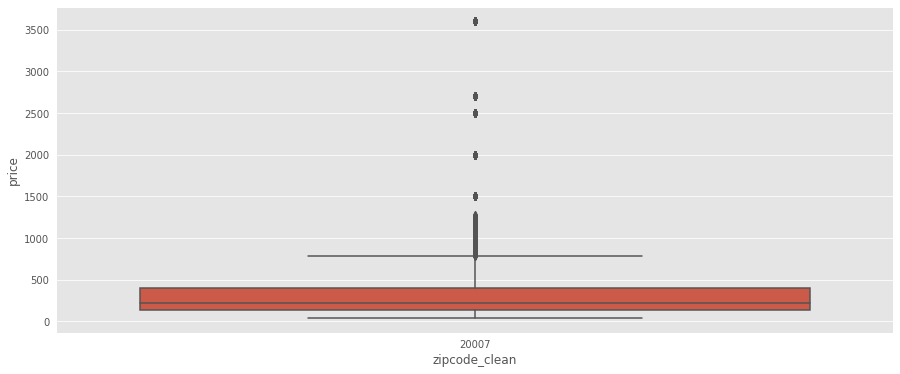

In [ ]:
testing = pd.DataFrame(listings_calendar[listings_calendar['zipcode_clean']=='20007'].reset_index(drop=True))

testing

plt.figure(figsize=(15,6))

g=sns.boxplot(y='price', x='zipcode_clean',data=testing)

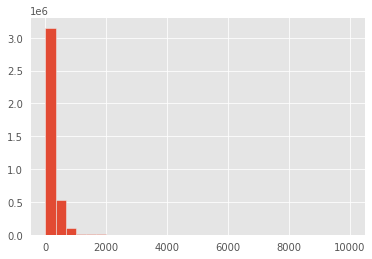

In [ ]:
plt.hist(listings_calendar['price'],bins = 30 )
None

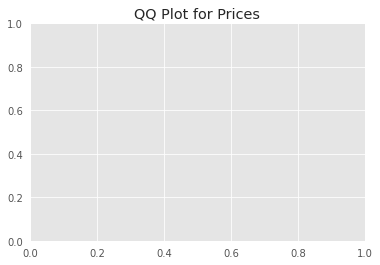

In [ ]:
stats.probplot(x=listings_calendar['price'], dist = "norm")
plt.title("QQ Plot for Prices")
plt.show()

In [ ]:
sns.lmplot(x='accommodates',y='price',data=listings_calendar, 
           line_kws = {'color': "red"} ,aspect= 2)
plt.title("Price vs. accommodates");